## Observational overdensities

Comparison to observed overdensities.

In [ ]:
import pandas as pd
import numpy as np

import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from scipy.optimize import curve_fit

from methods import bhattacharyya
from methods import plotit

from astropy.cosmology import Planck13

from methods import z_distort
from methods import factor_h
from methods import get_protoclusters
from methods import label
from methods import binit
from methods import fit_func
from methods import r2
from methods import overdensity_cylinder

h = 0.673
L = 480.279 / h # box side length

N = 100000    # number of random regions

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory = 'output/'

### Load data

In [ ]:
redshifts = ['3p10','3p95']  #,'8p22','8p93','9p72'] '2p07', ,'5p03','5p92','6p97'
zees = [float(z.replace('p','.')) for z in redshifts]

# gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, z in enumerate(redshifts):
    print i, z
    
#     gals_sfr[i] = pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
#                               skiprows=122, skipfooter=1, engine='python')
    
    gals_mstar[i] = pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python')

0 3p10


In [ ]:
gals_mstar10 = [None] * len(redshifts)

for i, z in enumerate(zees):
        
    gals_mstar[i] = z_distort(factor_h(gals_mstar[i], h), z, L)

    gals_mstar10[i] = gals_mstar[i][gals_mstar[i]['zn_stellarMass'] >= 1]

#         print "Filling in NaN values..."
    gals_mstar10[i].ix[np.isnan(gals_mstar10[i]['z0_haloId']), 'z0_haloId'] = -1
    gals_mstar10[i].ix[np.isnan(gals_mstar10[i]['z0_centralId']), 'z0_centralId'] = -1
    gals_mstar10[i].ix[np.isnan(gals_mstar10[i]['z0_central_mcrit200']), 'z0_central_mcrit200'] = 0
    

### Franck & McGaugh +16

Write protocluster candidate data in to a dataframe for ease of use. Redshift depth given by $z \pm \sigma_{z}$.

In [ ]:
name = ['CCPC-z27-002','CCPC-z29-001','CCPC-z29-002','CCPC-z30-001','CCPC-z30-003','CCPC-z31-003',
        'CCPC-z31-004','CCPC-z31-005','CCPC-z32-002','CCPC-z33-002','CCPC-z35-001','CCPC-z36-001']

redshift = [2.772,2.918,2.919,3.035,3.096,3.133,3.146,3.152,3.234,3.372,3.597,3.644]
deltaz = [0.007,0.005,0.009,0.005,0.008,0.008,0.006,0.007,0.003,0.008,0.003,0.003]

In [ ]:
dat = pd.DataFrame(data=[redshift, deltaz]).T
dat.index = name
dat.columns = ['redshift','deltaz']

Calculate $\Delta z$ in $\mathrm{cMpc}$

In [ ]:
dat['deltac'] = (Planck13.comoving_distance(dat.redshift+dat.deltaz) - \
                 Planck13.comoving_distance(dat.redshift-dat.deltaz)) / 2 # * Planck13.h

Add empty columns for calculated protocluster probabilities, and nearest redshift snapshot in Millennium.

In [ ]:
# dat['protocluster probability'] = pd.Series()
# dat['high mass probability'] = pd.Series()
# dat['part probability'] = pd.Series()
dat['dgal'] = [11.02,11.21,12.91,18.78,12.28,9.80,7.59,17.77,13.11,7.44,10.18,23.50]
dat['nearest snap'] = [3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.95,3.95]

dat

#### Calculate overdensity data

Need to calculate overdensity statistics for random regions over the whole box in order to get probabilities. 

First, find the coordinates of all protoclusters

In [8]:
group_coods = [None] * len(gals_mstar10)
group_coods[0] = get_protoclusters(gals_mstar10[0], L, cluster_lim=1.48e3)
group_coods[1] = get_protoclusters(gals_mstar10[1], L, cluster_lim=1.48e3)

Use to find limiting completeness and purity, and calculate overdensity stats.

In [28]:
# coods = pd.DataFrame(np.random.rand(N,3) * L, columns=['zn_x','zn_y','zn_z']) # generate random regions

# out_stats = {str(idx): {'stats': None, 'dgal': None, 'cmass': None, 'clim': None, 'plim': None} \
#                            for idx in dat.index}

# gal_idx = [0,0,0,0,0,0,0,0,0,0,1,1]

# for didx, gidx in zip(dat.index, gal_idx):
#     print didx, gidx

#     pc_mask = group_coods[gidx]['clusters']['z0_central_mcrit200'].values > 1.48e4
    
# #     print 'finding clim and plim' for protoclusters
#     c_p = overdensity_cylinder(gals_mstar10[gidx], group_coods[gidx]['coods'], 
#                         R=10, dc=dat.ix[didx]['deltac'], L=L, pc_stats=True)
    
#     out_stats[didx]['clim'] = (round(np.percentile(c_p[pc_mask,1], 95),3), 
#                                round(np.median(c_p[pc_mask,1],3)),
#                                round(np.percentile(c_p[pc_mask,1], 5),3))
    
#     out_stats[didx]['plim'] = (round(np.percentile(c_p[pc_mask,2], 95),3), 
#                                round(np.median(c_p[pc_mask,2],3)), 
#                                round(np.percentile(c_p[pc_mask,2], 5),3))
    
#     out_stats[didx]['dgal'] = c_p[:,0]
#     out_stats[didx]['cmass'] = group_coods[gidx]['clusters']['z0_central_mcrit200'].values
    
# #     print 'calculating stats'
#     out_stats[didx]['stats'] = overdensity_cylinder(gals_mstar10[gidx], coods, R=10, 
#                             dc=dat.ix[didx]['deltac'], L=L, pc_stats=True, verbose=False)
    

# pcl.dump(out_stats, open('out_stats_obs.p','w'))
out_stats = pcl.load(open('out_stats_obs.p','r'))

CCPC-z27-002
CCPC-z29-001
CCPC-z29-002
CCPC-z30-001
CCPC-z30-003
CCPC-z31-003
CCPC-z31-004
CCPC-z31-005
CCPC-z32-002
CCPC-z33-002
CCPC-z35-001
CCPC-z36-001


Calculate protocluster probabilities and estimate descendant masses:

In [81]:
for idx in dat.index:  # loop through observational candidates
    
    ### Protocluster Probability 
    if out_stats[idx]['clim'][2] == 0.: clim = 0.01
    else: clim = out_stats[idx]['clim'][2]
        
    if out_stats[idx]['plim'][2] == 0.: plim = 0.01
    else: plim = out_stats[idx]['plim'][2]
    
    labs, labels = label(out_stats[idx]['stats'], clim=clim, plim=plim)

    bins, binLimits, agg, agg_total, fracs = binit(out_stats[idx]['stats'], labs, labels)
    
    dgal = dat.ix[idx]['dgal']
    keys = labels[:4]
    
    print idx, "\nClim:", out_stats[idx]['clim'], "\nPlim:", out_stats[idx]['plim'], "\nP(dgal): %.3f"%\
    np.sum([fracs[key] for key in keys], axis=0)[np.where(binLimits < dgal)[0].max()], "\n"
    
    ### Descendant Mass Estimate 
    fit_mask = out_stats[idx]['dgal'] > 4.5

    x = np.zeros((out_stats[idx]['dgal'].shape[0], 2))  # create feature array

    x[:,0] = out_stats[idx]['dgal']
    x[:,1] = dat.ix[idx]['redshift']

    popt, pcov = curve_fit(fit_func, x[fit_mask,:].T, out_stats[idx]['cmass'][fit_mask], maxfev=20000)
    
    print "R^2: %.2f \nM_z=0: %.2f\n"%(r2(out_stats[idx]['cmass'][fit_mask], fit_func(x[fit_mask,:].T, popt[0], popt[1], popt[2], popt[3])),\
    np.log10(fit_func(dat.ix[idx][['dgal','redshift']], popt[0], popt[1], popt[2], popt[3]) * 1e10))
    

 CCPC-z27-002 
Clim: (1.0, 1.0, 0.80000000000000004) 
Plim: (1.0, 0.88888888888888884, 0.54545454545454541) 
P(dgal): 0.751 

R^2: 0.63 
M_z=0: 14.47

CCPC-z29-001 
Clim: (1.0, 1.0, 0.67333333333333334) 
Plim: (1.0, 1.0, 0.63636363636363635) 
P(dgal): 0.458 

R^2: 0.63 
M_z=0: 14.28

CCPC-z29-002 
Clim: (1.0, 1.0, 0.82085561497326198) 
Plim: (1.0, 0.8571428571428571, 0.5) 
P(dgal): 0.830 

R^2: 0.61 
M_z=0: 14.67

CCPC-z30-001 
Clim: (1.0, 1.0, 0.66666666666666663) 
Plim: (1.0, 1.0, 0.66666666666666663) 
P(dgal): 0.738 

R^2: 0.61 
M_z=0: 14.61

CCPC-z30-003 
Clim: (1.0, 1.0, 0.80000000000000004) 
Plim: (1.0, 0.88888888888888884, 0.54545454545454541) 
P(dgal): 0.743 

R^2: 0.63 
M_z=0: 14.55

CCPC-z31-003 
Clim: (1.0, 1.0, 0.80000000000000004) 
Plim: (1.0, 0.88888888888888884, 0.54545454545454541) 
P(dgal): 0.477 

R^2: 0.63 
M_z=0: 14.39

CCPC-z31-004 
Clim: (1.0, 1.0, 0.7142857142857143) 
Plim: (1.0, 1.0, 0.61805555555555558) 
P(dgal): 0.138 

R^2: 0.63 
M_z=0: 14.09

CCPC-z31-005 
C

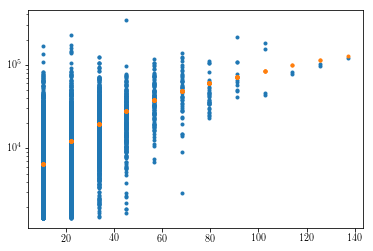

In [30]:
plt.plot(x[fit_mask,0], out_stats[didx]['cmass'][fit_mask], '.')
plt.semilogy(x[fit_mask,0], fit_func(x[fit_mask,:].T, popt[0], popt[1], popt[2], popt[3]), '.')